In [1]:
# Libraries

import matplotlib
import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.analysis import analysis_annotation
from source.python.data.analysis import analysis_assembly
from source.python.data.analysis import analysis_metadata
from source.python.data.analysis import analysis_statistics
from source.python.data.analysis import analysis_tpm
from source.python.io            import loader
from source.python.io            import writer
from source.python               import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp00-analysis')
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_GENOME = os.path.join(RES,      'genome')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f' Resource Directory : {RES_GENOME}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp00-analysis
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\genome


In [5]:
# Load and clean (remove non-relevant columns, rename columns to same format, etc..)

data = loader.load_resources(
	directory = RES_GENOME,
	plant     = 'arabidopsis-r36',
	clean     = True
)

gene_annotation = data['gene_annotation']
gene_assembly   = data['gene_assembly']
tissue_metadata = data['tissue_metadata']
tissue_tpm      = data['tissue_tpm']

# 2. Sync

In [6]:
# Drop mt and pt sequence annotations

mt = gene_annotation[(gene_annotation['Seq'] == 'Mt') & (gene_annotation['Type'] == 'mRNA')]
pt = gene_annotation[(gene_annotation['Seq'] == 'Pt') & (gene_annotation['Type'] == 'mRNA')]

print(f'Transcript (Mt) : ' + '{:}'.format(len(mt)))
print(f'Transcript (Pt) : ' + '{:}'.format(len(pt)))
print()

gcount = gene_annotation['Gene'].nunique()
tcount = gene_annotation['Transcript'].nunique()

gene_annotation = gene_annotation[~gene_annotation['Seq'].isin(['Pt'])]
gene_annotation = gene_annotation[~gene_annotation['Seq'].isin(['Mt'])]

print('Gene       : {:} -> {:}'.format(gcount, gene_annotation['Gene'].nunique(dropna = True)))
print('Transcript : {:} -> {:}'.format(tcount, gene_annotation['Transcript'].nunique(dropna = True)))

Transcript (Mt) : 120
Transcript (Pt) : 88

Gene       : 27628 -> 27420
Transcript : 48321 -> 48113


In [7]:
# Check for sample matching between tpm and metadata tables

x = set(tissue_metadata['Sample'].dropna())
y = set(tissue_tpm.columns[1:].dropna())

sample_i = list(x.intersection(y))
sample_x = list(x.difference(y))
sample_y = list(y.difference(x))

print(f'Samples in <tissue-metadata> : {len(sample_i)} / {len(x)}')
print(f'Samples in <tissue-tpm>      : {len(sample_i)} / {len(y)}')
print()
print(f'Samples missing in <tissue-metadata> : [{len(sample_y)}] ' + ' '.join(sample_y[:5]) + (' ...' if len(sample_y) > 5 else ''))
print(f'Samples missing in <tissue-tpm>      : [{len(sample_x)}] ' + ' '.join(sample_x[:5]) + (' ...' if len(sample_x) > 5 else ''))

if len(sample_x) > 0 :
	tissue_metadata = tissue_metadata[~tissue_metadata['Sample'].isin(sample_x)]

if len(sample_y) > 0 :
	tissue_tpm = tissue_tpm.drop(columns = sample_y)

Samples in <tissue-metadata> : 4138 / 4139
Samples in <tissue-tpm>      : 4138 / 4146

Samples missing in <tissue-metadata> : [8] SRR5591024 SRR5591030 SRR5591033 SRR5591023 SRR5591021 ...
Samples missing in <tissue-tpm>      : [1] DRR273449


# 3. Data

## 3.1 Gene Annotation

In [8]:
# Show the first few gene annotations

analysis_annotation.show(gene_annotation)

Number of rows : 438629
Number of cols : 10


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
2,1,+,mRNA,AT1G01010,AT1G01010.1,NaN,AT1G01010,3631,5899,2268
3,1,+,UTR5,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3631,3759,128
5,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3760,3913,153
7,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3996,4276,280
9,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4486,4605,119


In [9]:
# Inspect gene annotation columns, and dispay the number of unique values (as well as the first few values)

analysis_annotation.inspect_columns(
	data    = gene_annotation,
	columns = None
)

Unique values per column :

 - Seq        : [      5] 1 2 3 4 5
 - Strand     : [      2] + -
 - Type       : [      4] mRNA UTR5 CDS UTR3
 - Gene       : [ 27,420] AT1G01010 AT1G01020 AT1G01030 AT1G01040 AT1G01050 ...
 - Transcript : [ 48,113] AT1G01010.1 AT1G01020.6 AT1G01020.2 AT1G01020.3 AT1G01020.5 ...
 - Exon       : [      1] nan
 - Parent     : [ 75,533] AT1G01010 AT1G01010.1 AT1G01020 AT1G01020.6 AT1G01020.2 ...
 - Start      : [220,482] 3631 3760 3996 4486 4706 ...
 - End        : [220,484] 5899 3759 3913 4276 4605 ...
 - Length     : [  7,118] 2268 128 153 280 119 ...


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
Datatype,object,object,object,object,object,object,object,int32,int32,int32
Null,0,0,0,0,0,438629,0,0,0,0
Unique,5,2,4,27420,48113,1,75533,220482,220484,7118


In [10]:
# Display a full gene with all its regions

analysis_annotation.show(
	data     = gene_annotation,
	query    = 'AT1G01010.1',
	query_by = 'Transcript',
	rows     = None
)

Number of rows : 9
Number of cols : 10


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
2,1,+,mRNA,AT1G01010,AT1G01010.1,NaN,AT1G01010,3631,5899,2268
3,1,+,UTR5,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3631,3759,128
5,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3760,3913,153
7,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3996,4276,280
9,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4486,4605,119
11,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4706,5095,389
13,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5174,5326,152
14,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5439,5630,191
16,1,+,UTR3,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5631,5899,268


In [11]:
# Print number of genes and transcripts

print('      Gene IDs : {:,}'.format(gene_annotation['Gene'].nunique(dropna = True)))
print('Transcript IDs : {:,}'.format(gene_annotation['Transcript'].nunique(dropna = True)))

      Gene IDs : 27,420
Transcript IDs : 48,113


In [12]:
# Display region type count per gene

analysis_annotation.type_distribution(
	data    = gene_annotation,
	groupby = 'Transcript',
	regions = ['mRNA', 'UTR5', 'CDS', 'UTR3']
)

,Count,0,1,2,3,4,5+
mRNA,48113,0,48113,0,0,0,0
UTR5,56380,5402,31229,9476,1874,99,33
CDS,285828,0,7910,6664,5450,4638,23451
UTR3,48308,5791,37615,3612,1011,49,35


In [13]:
# Display the region length statistics per each region

analysis_annotation.length_statistics(
	data = gene_annotation
)

,Count,Mean,Std,Min,25%,50%,75%,Max
mRNA,48113.000,2660.272,1759.209,2.000,1582.000,2318.000,3303.000,27264.000
UTR5,56380.000,183.549,190.915,0.000,61.000,134.000,243.000,3679.000
CDS,285828.000,217.656,300.222,0.000,80.000,125.000,222.000,7760.000
UTR3,48308.000,275.153,205.004,0.000,161.000,240.000,339.000,4000.000


## 3.2 Gene Assembly

In [14]:
# Display the length and short nucleotide sequences for each chromosome

analysis_assembly.show(
	data = gene_assembly,
	head = 25,
	tail = 25
)

Sequence [1 ] with length [30,427,671] : CCCTAAACCCTAAACCCTAAACCCT ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [2 ] with length [19,698,289] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [3 ] with length [23,459,830] : NNNNNNNNNNNNNNNNNNNNNNNNN ... ACCCTAAACCCTAAACCCTAAACCC
Sequence [4 ] with length [18,585,056] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AAGGGTTTAGGGTTTAGGGTTTAGG
Sequence [5 ] with length [26,975,502] : TATACCATGTACCCTCAACCTTAAA ... GTTTAGGATTTAGGGTTTTTAGATC
Sequence [Mt] with length [   366,924] : GGATCCGTTCGAAACAGGTTAGCCT ... TCGCAGAATGGAAACAAACCGGATT
Sequence [Pt] with length [   154,478] : ATGGGCGAACGACGGGAATTGAACC ... TCATAATAACTTGGTCCCGGGCATC


In [15]:
# Display the nucleotide frequency withing each chromosome

analysis_assembly.show_nucleotide_frequency(
	data     = gene_assembly,
	relative = False
)

,A,T,C,G,N,W,Y,M,K,R,S,D
1,9709674,9697113,5435374,5421151,163958,124,82,76,53,36,30,0
2,6315641,6316348,3542973,3520766,2506,18,12,5,10,7,3,0
3,7484757,7448059,4258333,4262704,5966,2,2,2,0,4,1,0
4,5940546,5914038,3371349,3356091,3030,0,0,1,0,0,0,1
5,8621974,8652238,4832253,4858759,10278,0,0,0,0,0,0,0
Mt,102464,100190,82661,81609,0,0,0,0,0,0,0,0
Pt,48546,49866,28496,27570,0,0,0,0,0,0,0,0
Total,38223602,38177852,21551439,21528650,185738,144,96,84,63,47,34,1


## 3.3 Tissue Metadata

In [16]:
# Display the first few annotated samples

analysis_metadata.show(tissue_metadata)

Number of rows : 4138
Number of cols : 8


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
1,DRR273450,DRP006986,yes,no,mature,seedling,mature_seedling,control
2,DRR273451,DRP006986,yes,no,mature,seedling,mature_seedling,control
3,DRR273452,DRP006986,no,no,mature,seedling,mature_seedling,environmental
4,DRR273453,DRP006986,no,no,mature,seedling,mature_seedling,environmental
5,DRR273454,DRP006986,no,no,mature,seedling,mature_seedling,environmental


In [17]:
# Inspect sample annotation columns, and dispay the number of unique values (as well as the first few values)

analysis_metadata.inspect_columns(
	data    = tissue_metadata,
	columns = None
)

Unique values per column :

 - Sample       : [4,138] DRR273450 DRR273451 DRR273452 DRR273453 DRR273454 ...
 - Study        : [  277] DRP006986 DRP004882 DRP005301 DRP005881 DRP005877 ...
 - Control      : [    2] yes no
 - Senescence   : [    2] no yes
 - Age          : [    5] mature young missing senescence seed
 - Tissue       : [    8] seedling seed leaf root flower ...
 - Group        : [   18] mature_seedling young_seedling young_seed missing_seedling mature_leaf ...
 - Perturbation : [    8] control environmental unstressed chemical mutant ...


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
Datatype,object,object,object,object,object,object,object,object
Null,0,0,0,0,0,0,0,0
Unique,4138,277,2,2,5,8,18,8


In [18]:
# Display tissue samples

template = '{:' + str(tissue_metadata['Tissue'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for tissue, dataframe in tissue_metadata.groupby('Tissue') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(tissue, length, percent))

flower                  :   82 [  1.98 %]
leaf                    : 1566 [ 37.84 %]
other                   :   23 [  0.56 %]
root                    :  606 [ 14.64 %]
seed                    :  103 [  2.49 %]
seedling                : 1720 [ 41.57 %]
senescence_green        :   24 [  0.58 %]
senescence_reproductive :   14 [  0.34 %]


In [19]:
# Display age samples

template = '{:' + str(tissue_metadata['Age'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for age, dataframe in tissue_metadata.groupby('Age') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(age, length, percent))

mature     : 2915 [ 70.44 %]
missing    :  165 [  3.99 %]
seed       :   49 [  1.18 %]
senescence :   38 [  0.92 %]
young      :  971 [ 23.47 %]


In [20]:
# Display group samples

template = '{:' + str(tissue_metadata['Group'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for group, dataframe in tissue_metadata.groupby('Group') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(group, length, percent))

mature_flower           :   62 [  1.50 %]
mature_leaf             : 1442 [ 34.85 %]
mature_other            :   21 [  0.51 %]
mature_root             :  298 [  7.20 %]
mature_seed             :   82 [  1.98 %]
mature_seedling         : 1059 [ 25.59 %]
missing_flower          :   18 [  0.43 %]
missing_leaf            :  106 [  2.56 %]
missing_root            :   23 [  0.56 %]
missing_seedling        :   18 [  0.43 %]
senescence_green        :   24 [  0.58 %]
senescence_reproductive :   14 [  0.34 %]
young_flower            :    2 [  0.05 %]
young_leaf              :   18 [  0.43 %]
young_other             :    2 [  0.05 %]
young_root              :  285 [  6.89 %]
young_seed              :   21 [  0.51 %]
young_seedling          :  643 [ 15.54 %]


In [21]:
# Display perturbation samples

template = '{:' + str(tissue_metadata['Perturbation'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for group, dataframe in tissue_metadata.groupby('Perturbation') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(group, length, percent))

chemical      :  734 [ 17.74 %]
control       : 1197 [ 28.93 %]
dna           :   51 [  1.23 %]
environmental : 1065 [ 25.74 %]
mechanical    :  128 [  3.09 %]
mutant        :  690 [ 16.67 %]
unknown       :   33 [  0.80 %]
unstressed    :  240 [  5.80 %]


## 3.4 Tissue TPM

In [22]:
# Display the first few tpm values

analysis_tpm.show(tissue_tpm)

Number of rows : 48359
Number of cols : 4139


,Transcript,DRR090011,DRR090012,DRR090013,DRR090014,DRR090015,DRR090016,DRR090017,DRR090018,DRR090019
0,AT1G01010.1,17.954,19.723,30.892,25.349,29.913,17.373,25.465,32.010,33.053
1,AT1G01020.1,2.140,0.000,0.502,1.455,2.084,0.000,1.565,0.626,0.061
2,AT1G01020.2,11.185,8.385,10.543,12.320,9.219,8.170,8.460,9.685,10.080
3,AT1G01020.3,0.000,0.000,2.558,0.000,0.006,2.017,1.933,0.000,0.000
4,AT1G01020.4,3.149,3.576,0.000,1.396,0.574,1.419,1.615,2.902,2.887


In [23]:
# Print the global tpm statistics

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

print('   Max TPM : {:13,.5f}'.format(numpy.max(matrix)))
print('  Mean TPM : {:13,.5f}'.format(numpy.mean(matrix)))
print('Median TPM : {:13,.5f}'.format(numpy.median(matrix)))
print('   Min TPM : {:13,.5f}'.format(numpy.min(matrix)))

   Max TPM : 586,287.00000
  Mean TPM :      20.67867
Median TPM :       1.11111
   Min TPM :       0.00000


In [24]:
# Print the amoutn of tpm reading below or equal 1.0

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 1.0)
other = total - where

print('   Total elements : {:11,d}'.format(total))
print('Non Zero elements : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('    Zero elements : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

   Total elements : 200,109,542
Non Zero elements :  97,791,328 [48.87 %]
    Zero elements : 102,318,214 [51.13 %]


In [25]:
# Print the amoutn of tpm reading below or equal 0.0

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 0.0)
other = total - where

print('Elements          : {:11,d}'.format(total))
print('Elements <= 0.000 : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('Elements >  0.000 : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

Elements          : 200,109,542
Elements <= 0.000 :  53,962,183 [26.97 %]
Elements >  0.000 : 146,147,359 [73.03 %]


In [26]:
# Add small shift to zeros

tissue_tpm = tissue_tpm.replace(to_replace = 0.0, value = 0.001, inplace = False)

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 0.001)
other = total - where

print('Elements          : {:11,d}'.format(total))
print('Elements <= 0.001 : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('Elements >  0.001 : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

Elements          : 200,109,542
Elements <= 0.001 :  57,150,130 [28.56 %]
Elements >  0.001 : 142,959,412 [71.44 %]


# 4. Plots

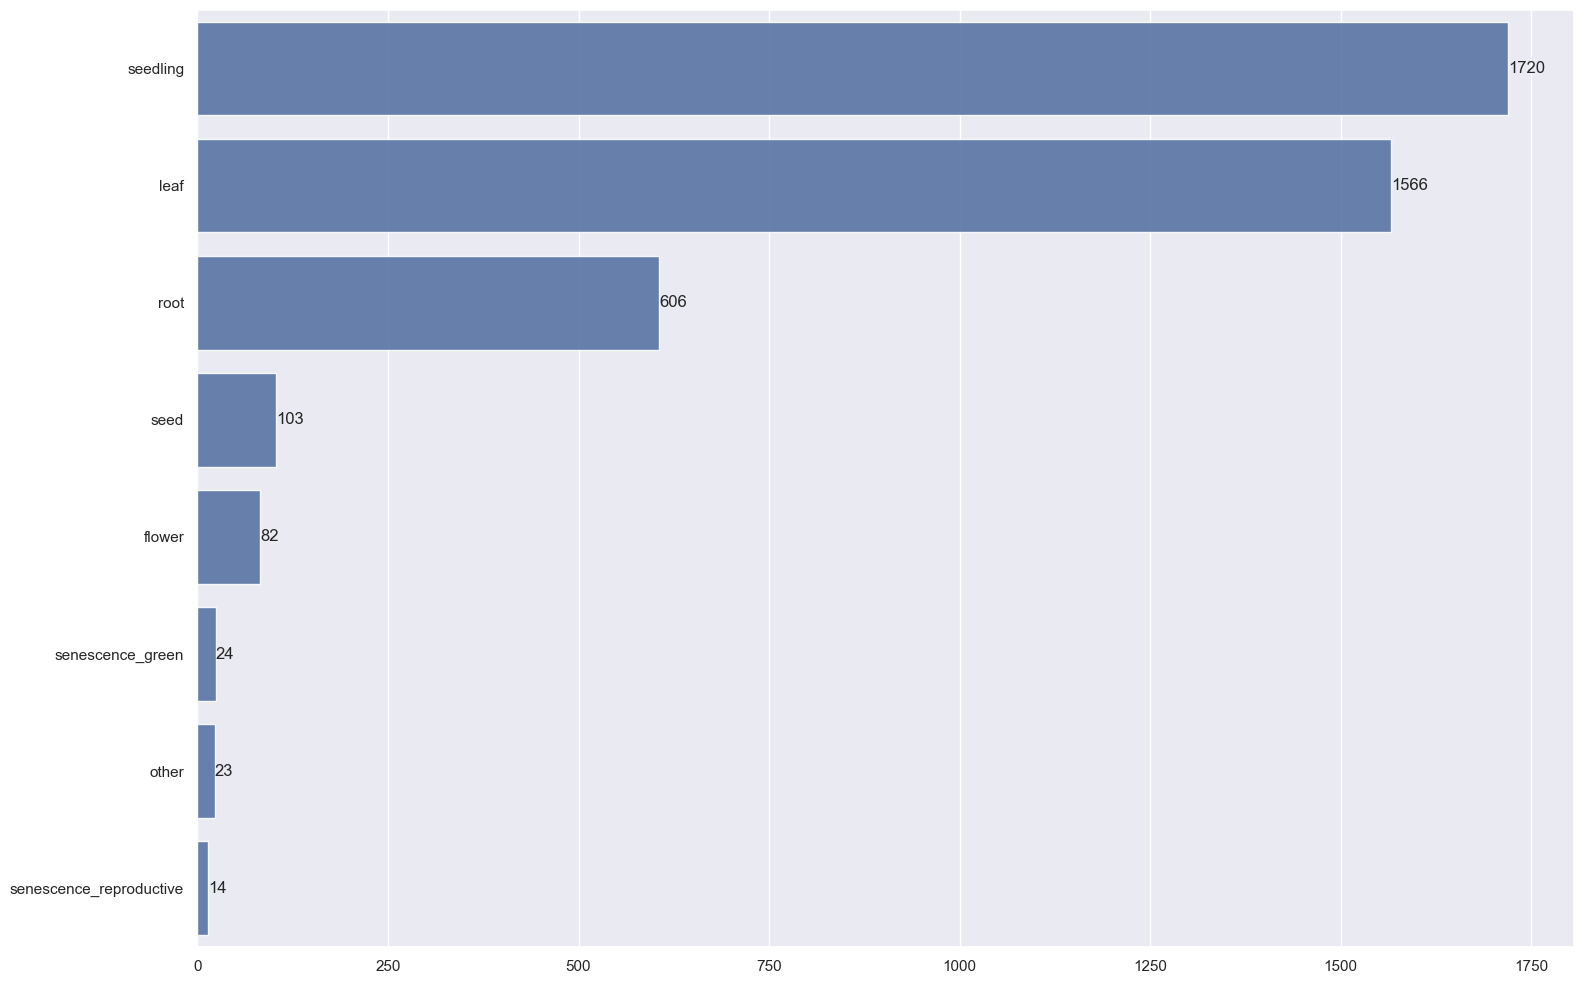

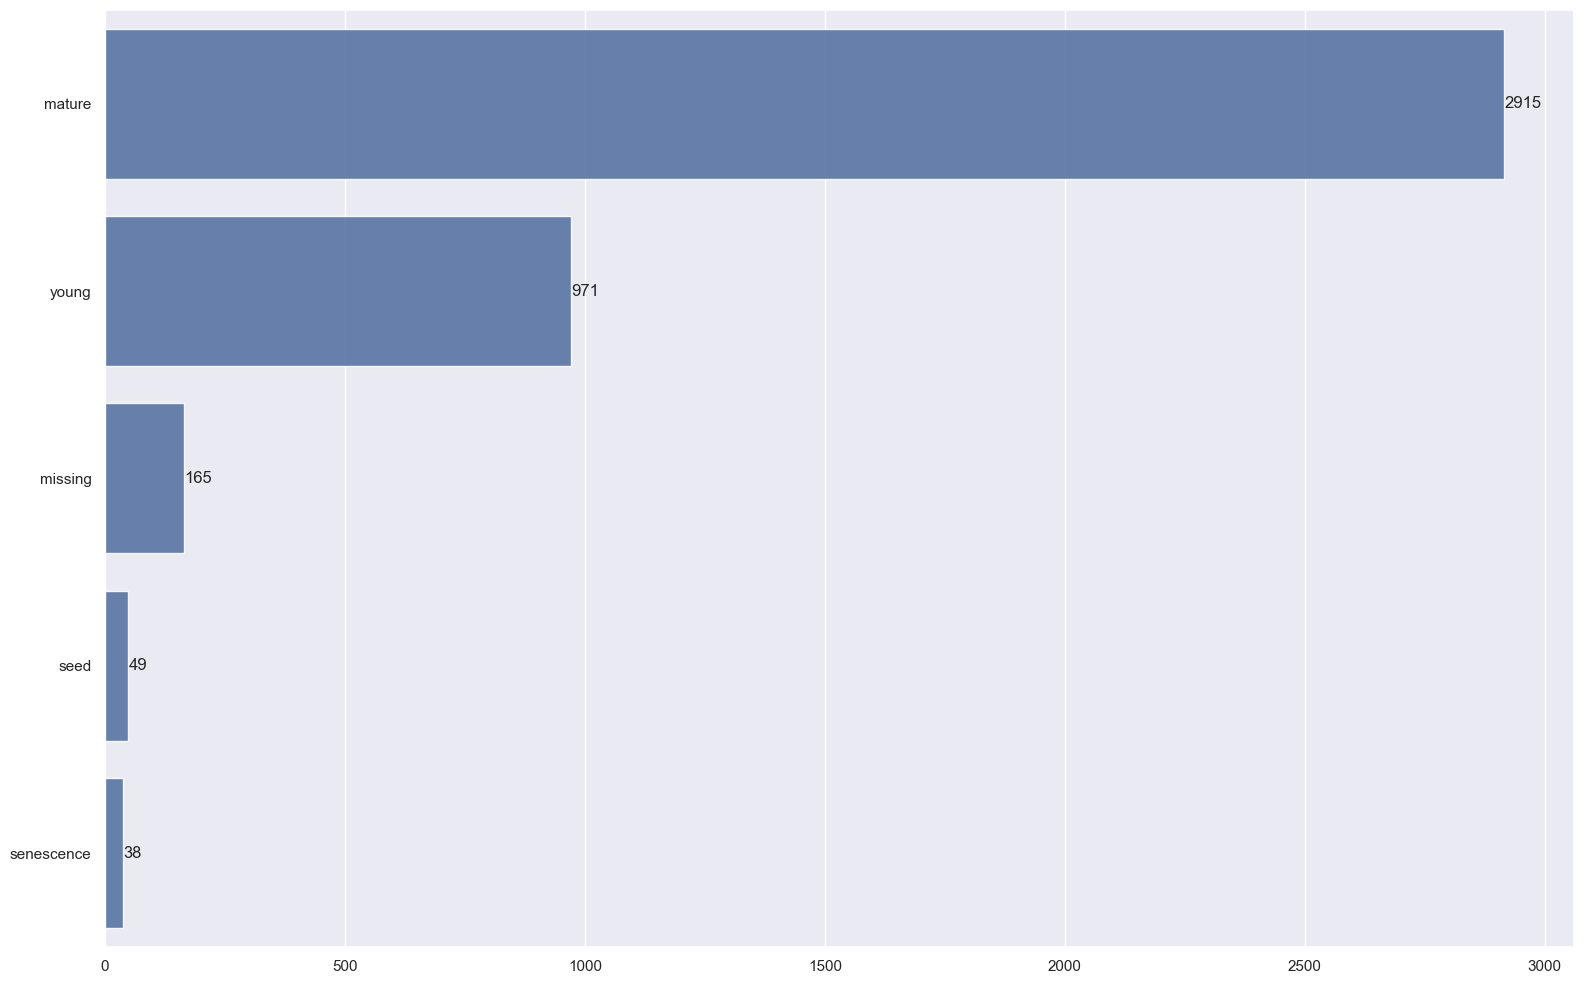

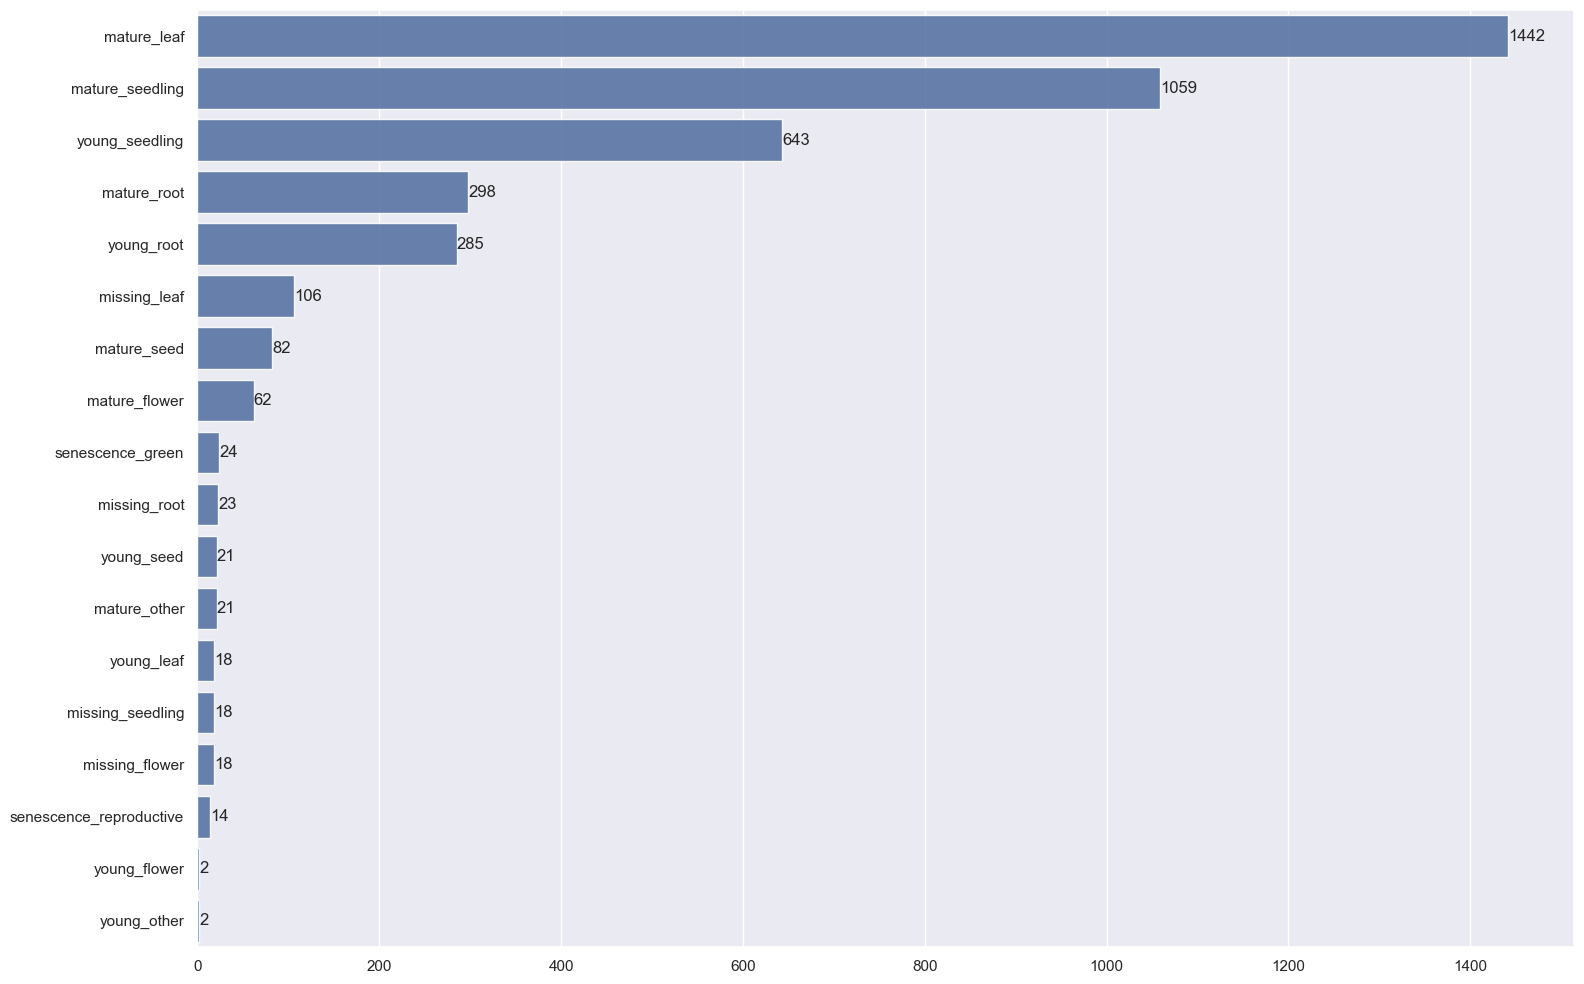

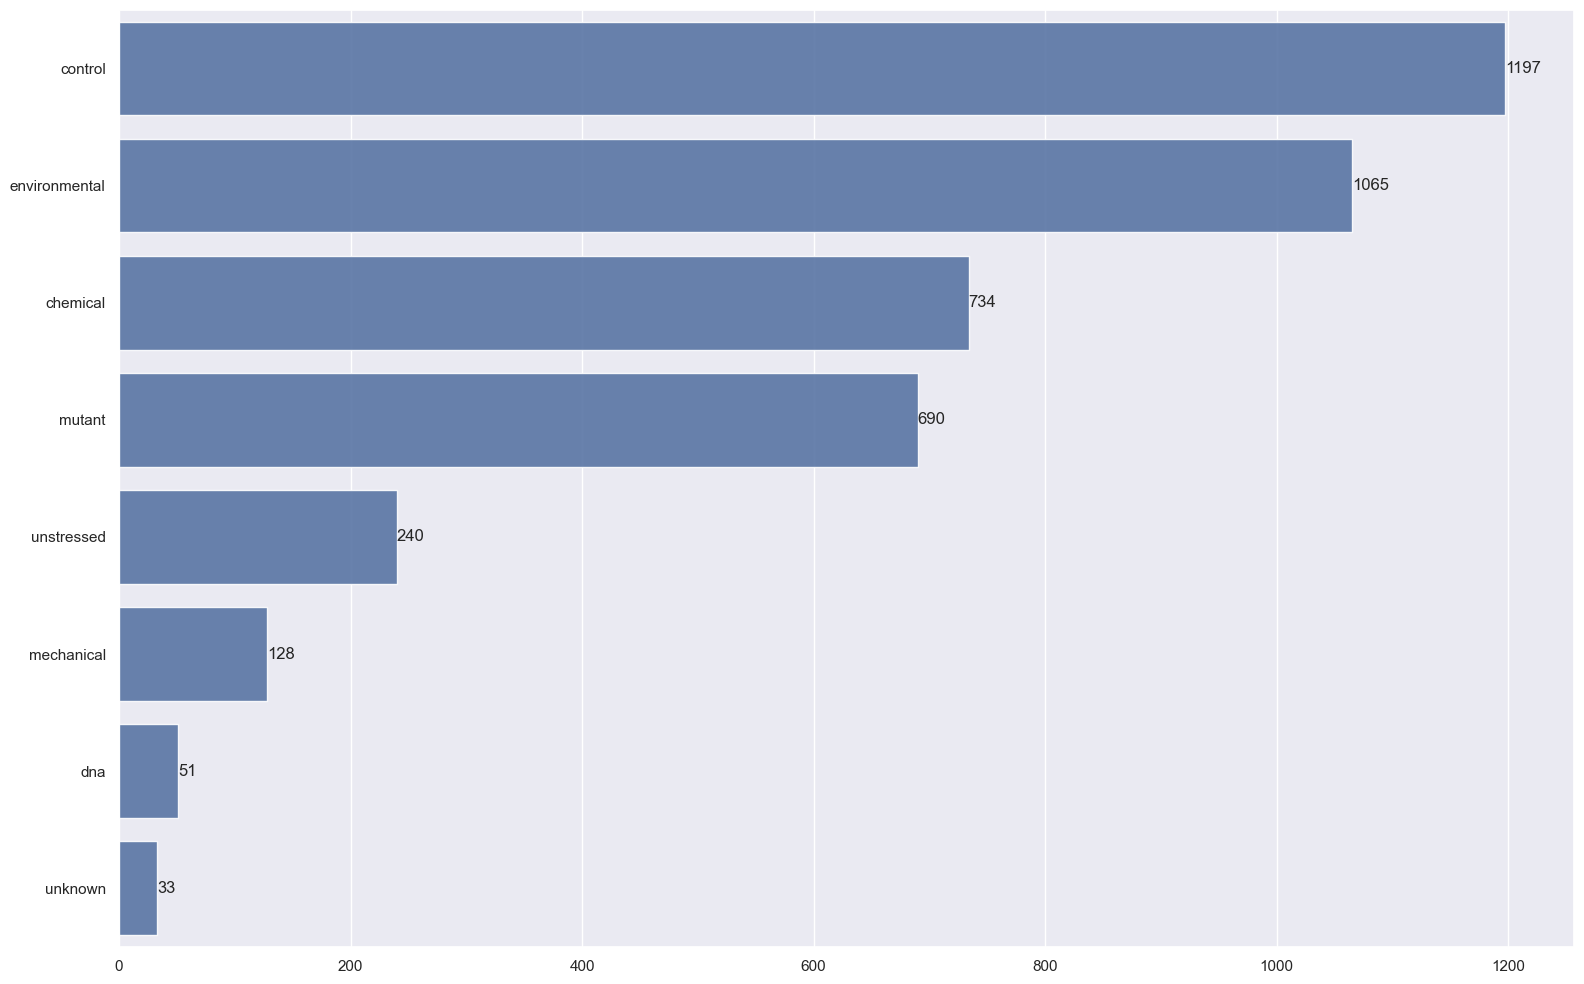

In [27]:
# Display the distribution of groups for all samples

for group in ['tissue', 'age', 'group', 'perturbation'] :
	analysis_metadata.distribution_barplot(
		data     = tissue_metadata,
		group    = group.capitalize(),
		filename = os.path.join(OUT_PLOT, 'distribution-' + group)
	)

	matplotlib.pyplot.show()

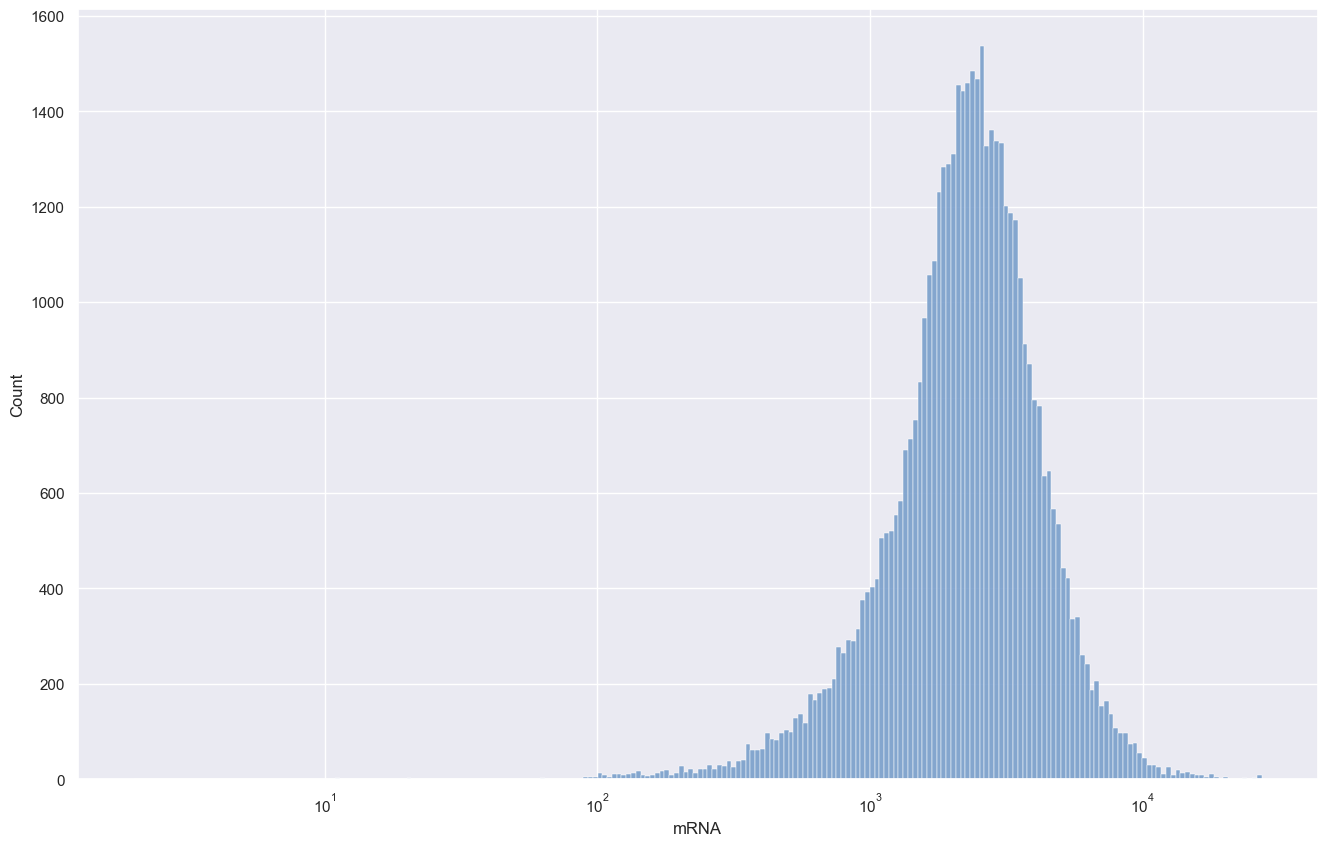

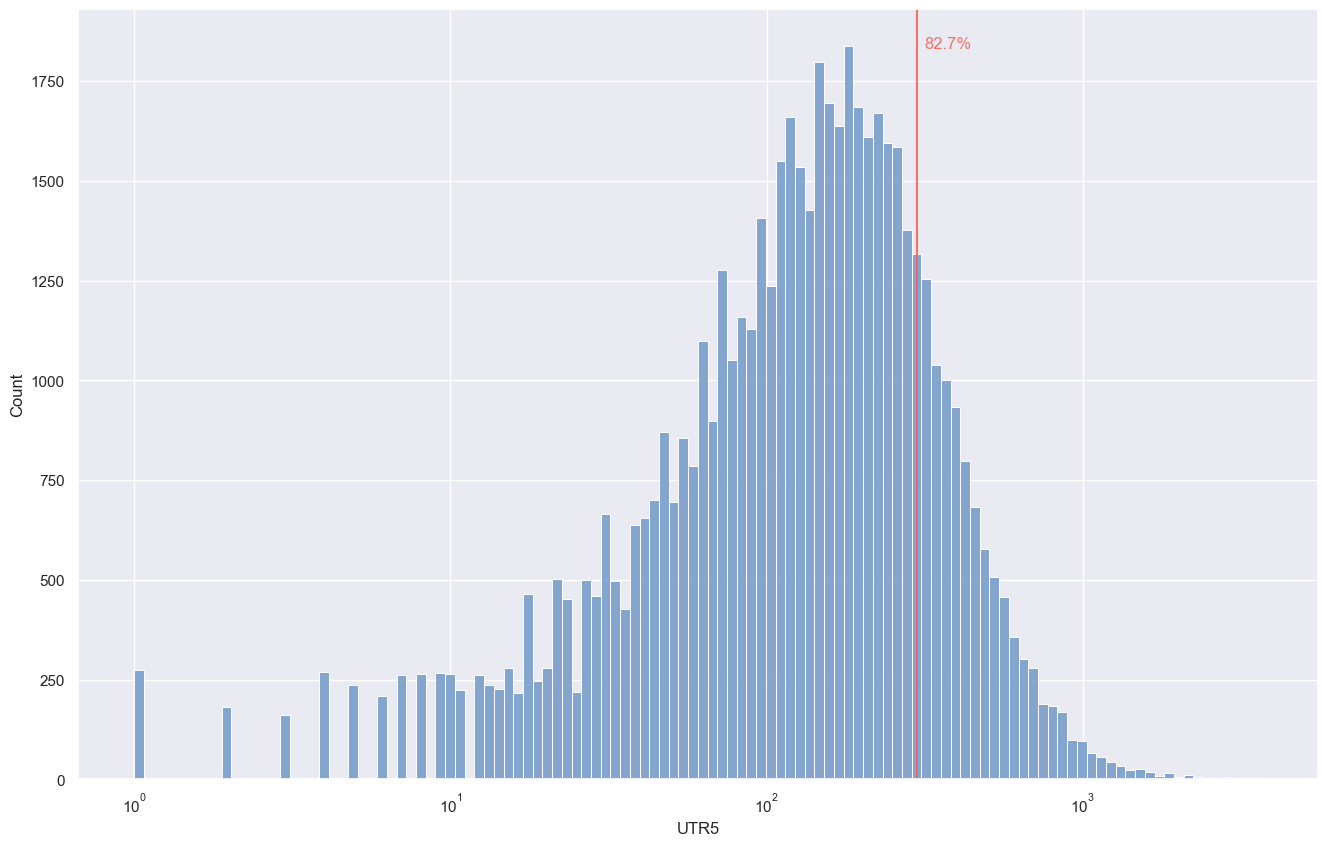

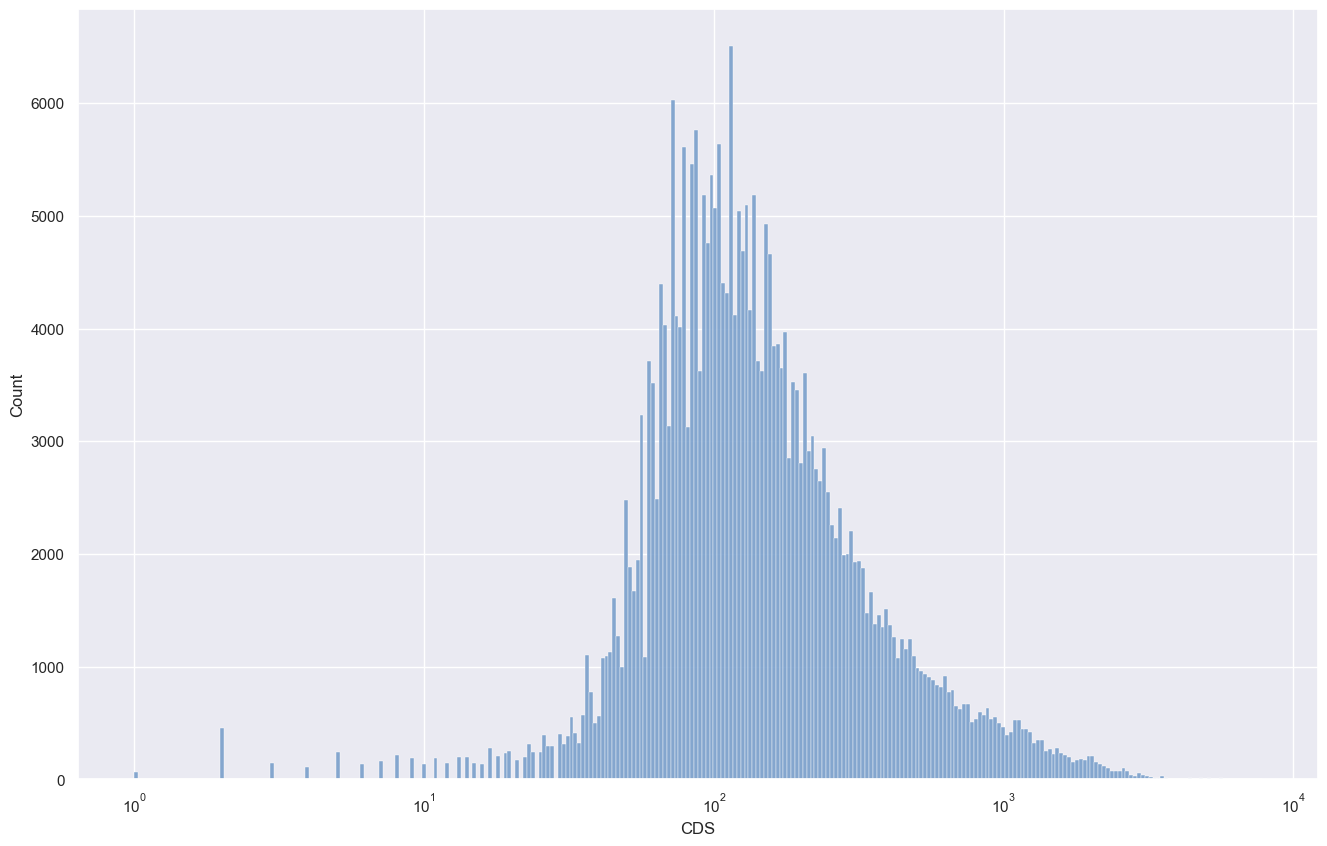

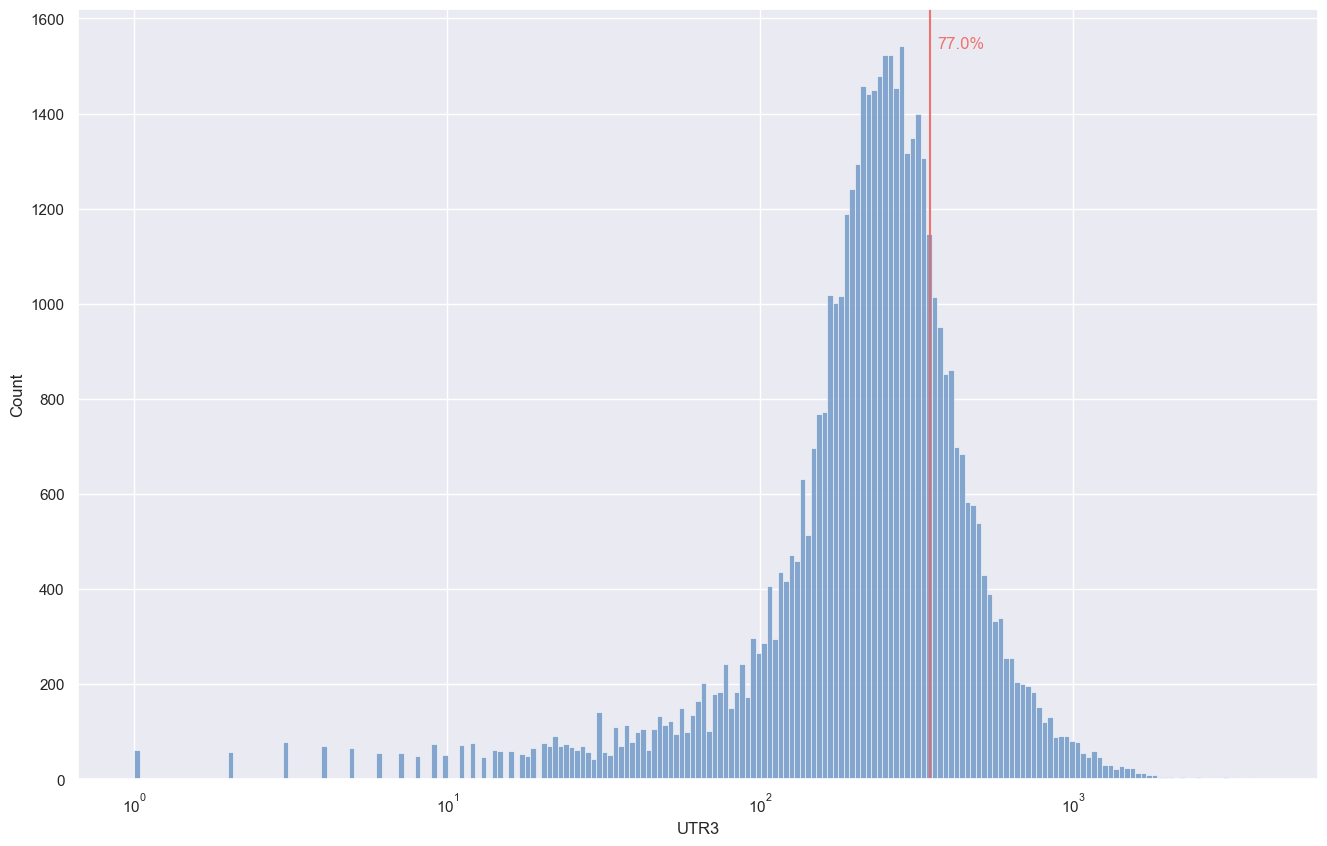

In [28]:
# Display the region length distributions per each region

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = gene_annotation,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-region-' + group.lower())
		)

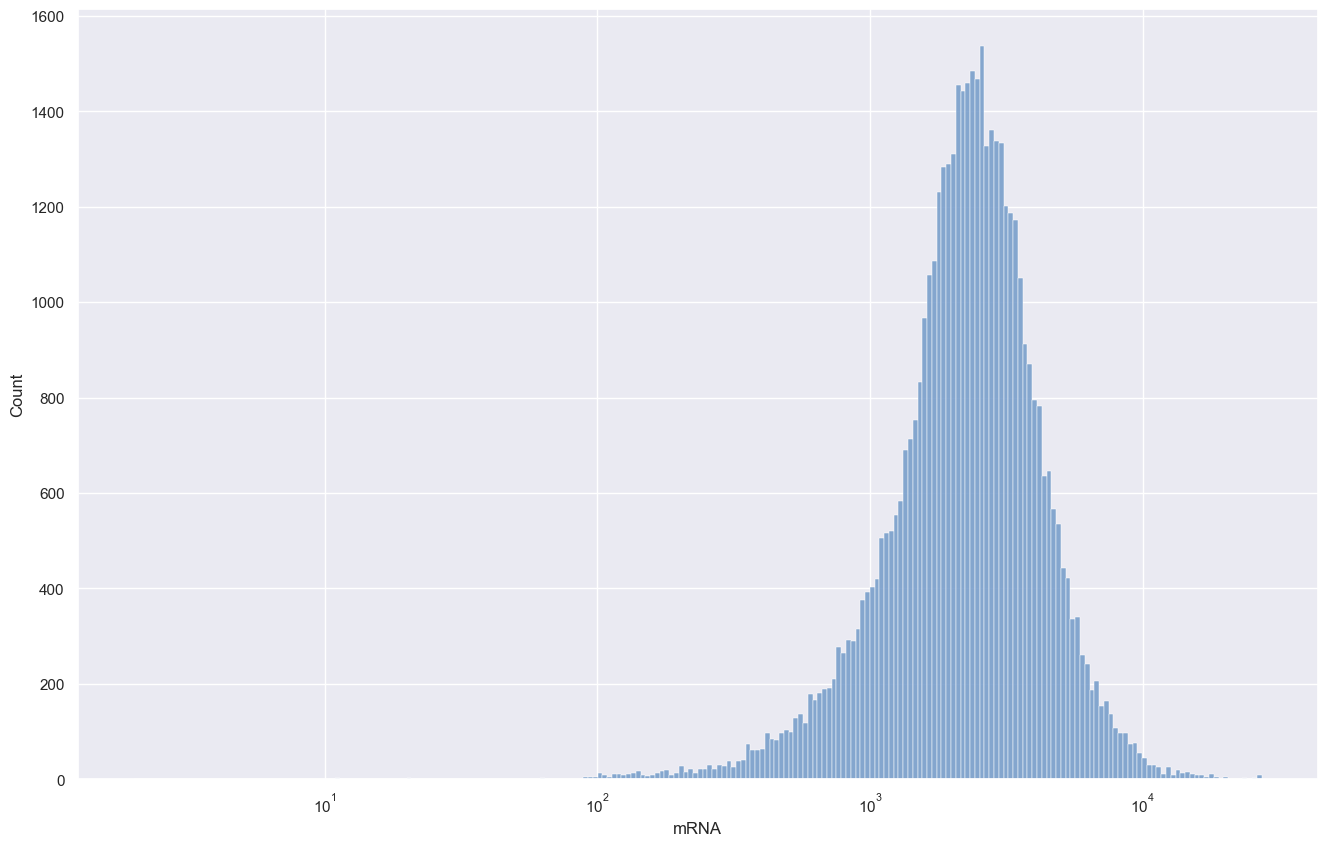

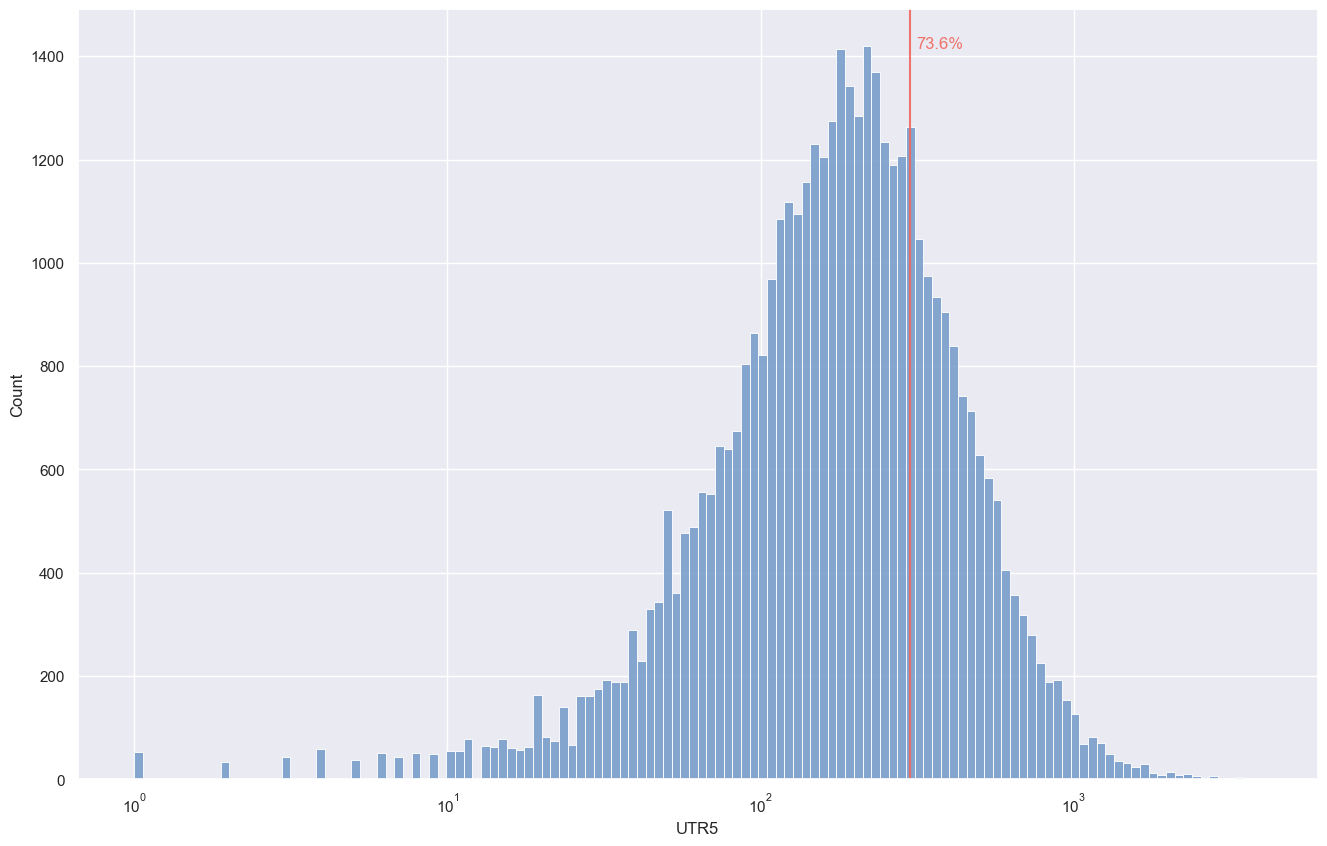

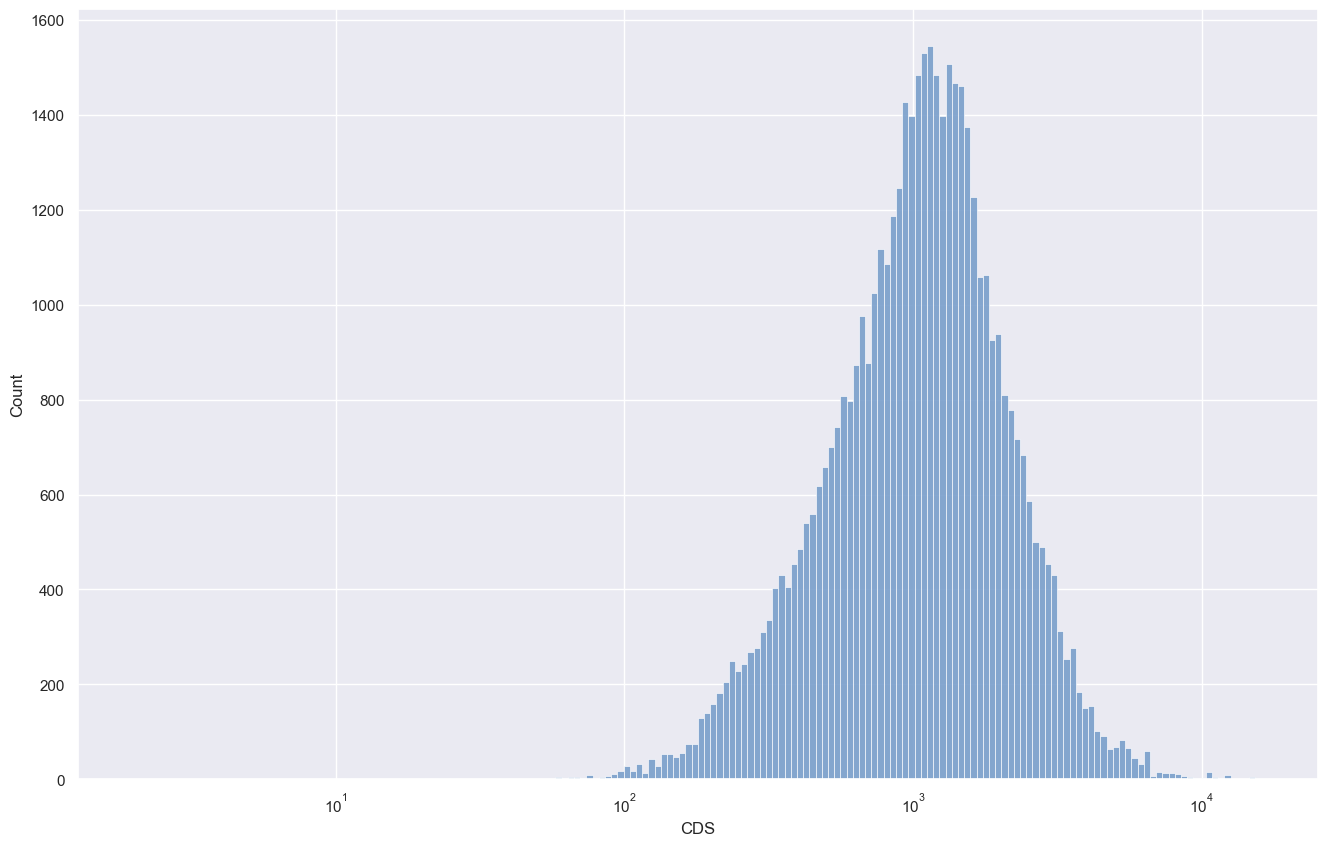

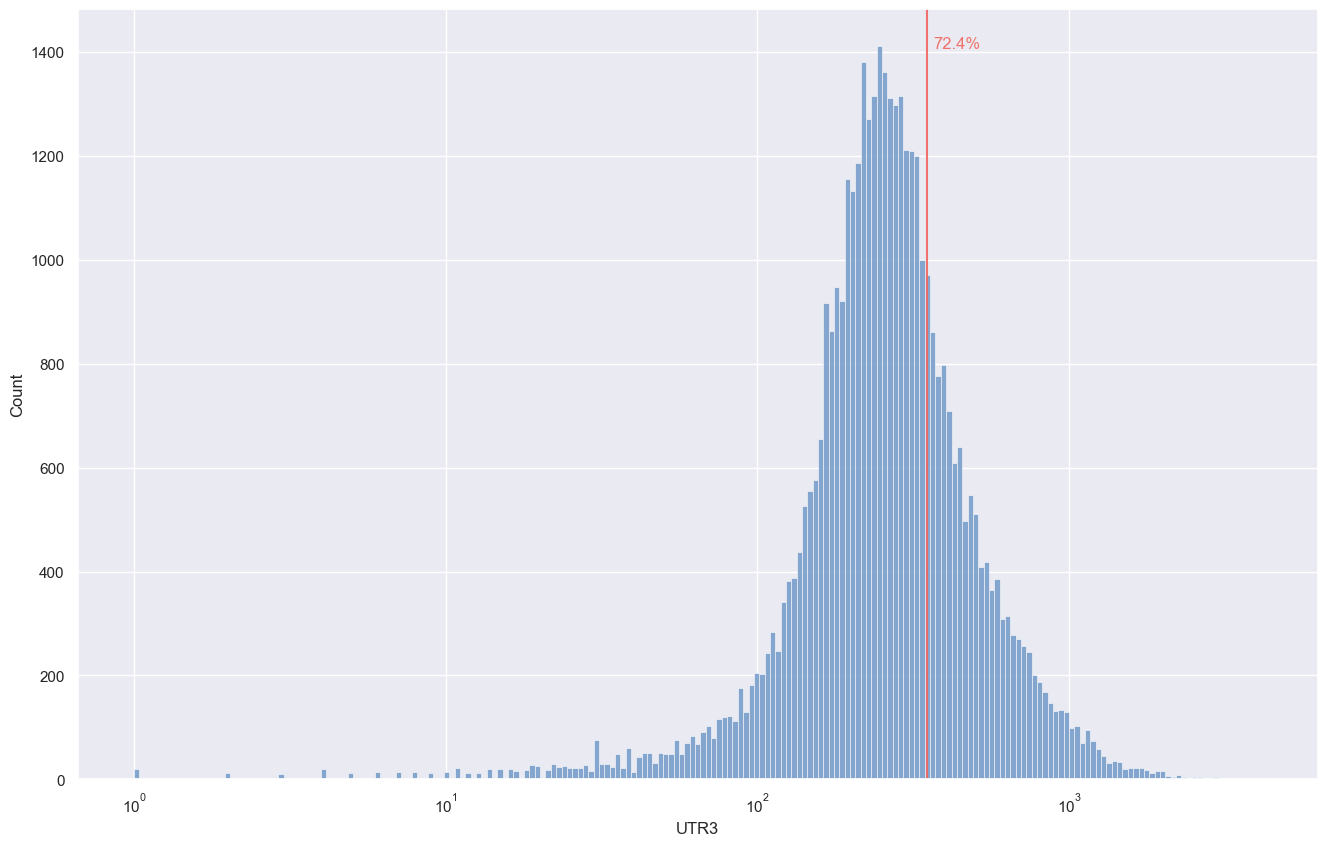

In [29]:
# Display the region length distributions per each region (grouped regions)

dataframe = analysis_annotation.group_regions(
	data    = gene_annotation,
	groupby = 'Transcript',
	regions = ['mRNA', 'UTR5', 'CDS', 'UTR3']
)

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = dataframe,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-transcript-' + group.lower())
		)

# 5. Groups

In [30]:
# Get the samples per tissue

samples_tissue = dict()

for group in tissue_metadata['Tissue'].unique() :
	samples_tissue[group] = tissue_metadata[tissue_metadata['Tissue'] == group]['Sample'].tolist()

# 6. Statistics

In [31]:
# Compute statistics for global

transcripts = tissue_tpm.iloc[:, 0 ].values

data = analysis_statistics.get_statistics_for(
	dataframe   = tissue_tpm,
	transcripts = transcripts,
	group       = 'Global',
	data        = None
)

In [32]:
# Compute statistics per tissue

for tissue in samples_tissue.keys() :
	data = analysis_statistics.get_statistics_for(
		dataframe   = tissue_tpm[samples_tissue[tissue]],
		transcripts = transcripts,
		group       = tissue.capitalize(),
		data        = data
	)

In [33]:
# Statistics to dataframe

dataframe = analysis_statistics.get_statistics_dataframe(
	data = data
)

dataframe.head(n = 9)

Mean   Min     Max  Median  StDev  \
Transcript  Tissue                                                        
AT1G01010.1 Flower                   6.646 2.385  23.810   5.379  3.834   
            Global                  10.922 0.001 130.383   6.552 12.395   
            Leaf                     5.918 0.001  89.863   3.506  7.922   
            Other                    5.243 0.266  21.868   2.958  5.441   
            Root                    26.687 0.938 130.383  26.008 16.548   
            Seed                     7.109 0.359  61.140   4.877  8.883   
            Seedling                10.496 0.001 103.324   8.013  9.679   
            Senescence_Green        13.756 0.001  60.184  11.910 14.890   
            Senescence_Reproductive  0.453 0.001   2.265   0.302  0.581   

                                     Variance    P75    P25   Range  
Transcript  Tissue                                                   
AT1G01010.1 Flower                     14.696  7.495  3.980  21.425  
            Global                    153.635 13.438  3.216 130.382  
            Leaf                       62.766  6.478  1.950  89.862  
            Other                      29.600  7.749  0.725  21.602  
            Root                      273.846 32.579 16.964 129.445  
            Seed                       78.916  6.635  3.305  60.780  
            Seedling                   93.677 12.566  4.974 103.323  
            Senescence_Green          221.712 16.178  2.402  60.183  
            Senescence_Reproductive     0.337  0.534  0.001   2.264

# 7. Save

In [34]:
# Save the updated and synchronized tables

writer.write_csv(
	data         = tissue_metadata,
	filename     = os.path.join(OUT_DATA, 'tissue-metadata.csv'),
	write_index  = False
)

writer.write_csv(
	data        = tissue_tpm,
	filename    = os.path.join(OUT_DATA, 'tissue-tpm.csv'),
	write_index = False
)

writer.write_csv(
	data        = gene_annotation,
	filename    = os.path.join(OUT_DATA, 'gene-annotation.csv'),
	write_index = False
)

writer.write_csv(
	data        = dataframe,
	filename    = os.path.join(OUT_DATA, 'statistics.csv'),
	write_index = True
)